## Foundation model to run NVT simulation

Adapted from: https://mace-docs.readthedocs.io/en/latest/examples/foundation_examples.html

Links to the MACE tutorials:
- https://colab.research.google.com/drive/1ZrTuTvavXiCxTFyjBV4GqlARxgFwYAtX#scrollTo=UIdFlyFDw9cy
- https://colab.research.google.com/drive/1oCSVfMhWrqHTeHbKgUSQN9hTKxLzoNyb
- https://colab.research.google.com/drive/1AlfjQETV_jZ0JQnV5M3FGwAM2SGCl2aU

Working with LAMMPS (discouraged, slow and doesn't run in single precision):
- https://mace-docs.readthedocs.io/en/latest/guide/lammps.html
- https://docs.lammps.org/Build_extras.html#kokkos
- https://github.com/ACEsuit/mace-mp/releases/tag/mace_mp_0

Other material
- MACE ASE interface https://mace-docs.readthedocs.io/en/latest/guide/ase.html
- Colab by F. Mambretti: https://github.com/francescomambretti/atomsim_energy_mlp

## Sanity checks on energy conservation

In [1]:
!ls

co_fe_ni.data		log.lammps   md_test_backup.log  test_init.data
co_fe_ni.xyz		md_3bpa.xyz  md_test_backup.xyz  workflow.ipynb
cu.data			md_cu.log    md_test.log
cu.xyz			md_cu.xyz    md_test.xyz
generate-cofeni.lammps	md.log	     test_300K.xyz


In [2]:
!mv md_test.xyz md_test_backup.xyz
!mv md_test.log md_test_backup.log

In [3]:
from ase.io import read, write
from ase import units
from ase.md.velocitydistribution import Stationary, ZeroRotation, MaxwellBoltzmannDistribution

from ase.md.langevin import Langevin

# For some reason these modules are not found:
# from ase.md.nose_hoover_chain import NoseHooverChainNVT
# from ase.md.bussi import Bussi

import random
import time
import numpy as np

FS2PS = 1e-3
FS2NS = 1e-6
DAY2MIN = 1440

In [4]:
def test_md(init_conf, 
            calc, 
            Propagator=Langevin, 
            dt=1.0, 
            T=300, 
            tdamp=0.01/units.fs, 
            nsteps=100, 
            fname='md_test.xyz',
            logfile='md_test.log',
            ndump=1, 
            seed=1234):
    
    """
        dt [fs]
        T [K]
        tdamp [???]
    """
    
    init_conf.calc = calc

    # Making sure the MD failure is reproducible
    random.seed(seed)
    # Initialize the temperature
    MaxwellBoltzmannDistribution(init_conf, temperature_K=T)
    
    # Remove COM and rotational velocity
    Stationary(init_conf)
    ZeroRotation(init_conf)

    # Drive system in the NVT ensemble
    dyn = Propagator(init_conf, dt*units.fs, temperature_K=T, friction=tdamp, logfile=logfile)

    # %matplotlib inline

    time_ps = []
    temperature = []
    energies = []

    def write_frame():
            dyn.atoms.write(fname, append=True)
            time_ps.append(FS2PS*dyn.get_time()/units.fs)
            temperature.append(dyn.atoms.get_temperature())
            energies.append(dyn.atoms.get_potential_energy()/len(dyn.atoms))

    dyn.attach(write_frame, interval=ndump)
    t0 = time.time()
    dyn.run(nsteps)
    t1 = time.time()
    cpu_run_min = (t1-t0)/60
    print("MD finished in {0:.2f} minutes!".format(cpu_run_min))
    print("Estimate: ",FS2NS*DAY2MIN*(nsteps*dt)/cpu_run_min," ns/day")
    
    return time_ps, temperature, energies

In [5]:
import mace
print(mace.__version__)

0.3.8


In [6]:
# If you want to run with cuEquivariance
!pip install cuequivariance==0.1.0 cuequivariance-torch==0.1.0 cuequivariance-ops-torch-cu12==0.1.0

In [7]:
from mace.calculators import MACECalculator

model_file = '/home/michele/lammps-mace/models/mace-mpa-0-medium.model'
# model_file = '/home/michele/lammps-mace/models/2023-12-10-mace-128-L0_energy_epoch-249.model'
calc = MACECalculator(model_paths=model_file, device='cuda', default_dtype="float32")

# Testing with cuEquivariance, NB needs MACE version 0.1.0 (?)
# calc = MACECalculator(model_paths=model_file, device='cuda', default_dtype="float32", enable_cueq=True)

/home/michele/mambaforge/envs/workflow-hea/lib/python3.10/site-packages/e3nn/o3/_wigner.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  _Jd, _W3j_flat, _W3j_indices = t

Default dtype float32 does not match model dtype float64, converting models to float32.


In [8]:
# Alternative way to define the calculator
# from mace.calculators import mace_mp
# calc = mace_mp() # return the default medium ASE calculator equivalent to mace_mp(model="medium")
# calc = mace_mp(model="large") # return a larger model
# calc = mace_mp(model="https://tinyurl.com/y7uhwpje") # downlaod the model at the given url
# calc = mace_mp(dispersion=True) # return a model with D3 dispersion correction

In [9]:
# LAMMPS Cu EAM benchmark
init_conf = read('cu.xyz', '0')

In [10]:
# A small CoFeNi box 
# init_conf = read('co_fe_ni.xyz', '0')

In [11]:
t, T, E = test_md(init_conf, calc, Propagator=Langevin, nsteps=100, ndump=10)

MD finished in 0.35 minutes!
Estimate:  0.4081250480258424  ns/day


<IPython.core.display.Javascript object>


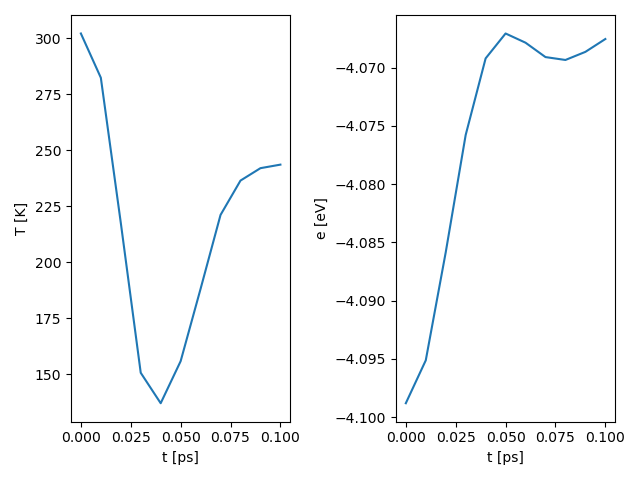

In [12]:
import matplotlib.pyplot as plt
%matplotlib notebook
fig, (ax1,ax2) = plt.subplots(1,2)
ax1.plot(t,T)
ax1.set_xlabel('t [ps]')
ax1.set_ylabel('T [K]')
ax2.plot(t,E)
ax2.set_xlabel('t [ps]')
ax2.set_ylabel('e [eV]')
plt.tight_layout()
plt.show()